# Book Clustering Statistics

This notebook provides statistics on the results of our book clustering.

## Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Load Data

Let's start by getting our clusters and their statistics:

In [2]:
clusters = pd.read_parquet('book-links/cluster-stats.parquet')
clusters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27925691 entries, 0 to 27925690
Data columns (total 8 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   cluster        int32 
 1   n_nodes        uint32
 2   n_isbns        uint32
 3   n_loc_recs     uint32
 4   n_ol_editions  uint32
 5   n_ol_works     uint32
 6   n_gr_books     uint32
 7   n_gr_works     uint32
dtypes: int32(1), uint32(7)
memory usage: 852.2 MB


In [3]:
clusters.set_index('cluster', inplace=True)

Describe the count columns for basic descriptive stats:

In [4]:
clusters.describe()

,n_nodes,n_isbns,n_loc_recs,n_ol_editions,n_ol_works,n_gr_books,n_gr_works
count,2.792569e+07,2.792569e+07,2.792569e+07,2.792569e+07,2.792569e+07,2.792569e+07,2.792569e+07
mean,2.994550e+00,8.774559e-01,3.462970e-01,9.547825e-01,6.769805e-01,8.453345e-02,5.450042e-02
std,7.375757e+00,3.660644e+00,5.648575e-01,2.670434e+00,7.561602e-01,1.120087e+00,2.350896e-01
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
75%,4.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
max,1.734900e+04,7.976000e+03,6.120000e+02,5.096000e+03,2.368000e+03,3.118000e+03,8.800000e+01


75% of clusters only contain 2 ISBNs (probably -10 and -13) and one book. OpenLibrary also contributes to the largest number of clusters.

## Clusters per Source

How many clusters are connected to each source?

In [5]:
src_counts = pd.Series(dict(
    (c, np.sum(clusters[c] > 0)) for c in clusters.columns
))
src_counts

n_nodes          27925691
n_isbns          13201869
n_loc_recs        9314956
n_ol_editions    20525956
n_ol_works       17723553
n_gr_books        1509661
n_gr_works        1509137
dtype: int64

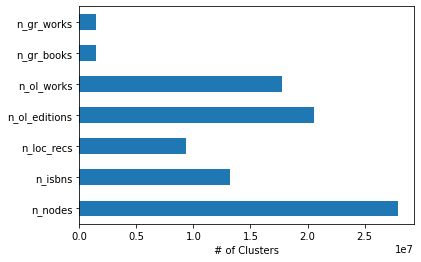

In [6]:
src_counts.plot.barh()
plt.xlabel('# of Clusters')
plt.show()

## Distributions

Let's look at the distributions of cluster sizes.

In [7]:
size_dist = pd.concat(dict(
    (c, clusters[c].value_counts()) for c in clusters.columns if c != 'n_nodes'
), names=['RecType'])
size_dist.index.set_names(['RecType', 'RecCount'], inplace=True)
size_dist = size_dist.reset_index(name='Clusters')
size_dist.head()

,RecType,RecCount,Clusters
0,n_isbns,0,14723822
1,n_isbns,2,6256782
2,n_isbns,1,5807972
3,n_isbns,4,551072
4,n_isbns,3,268793


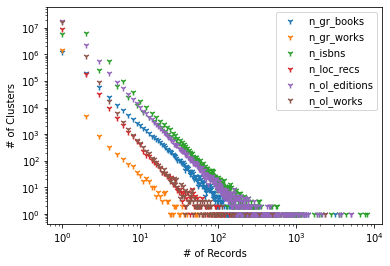

In [8]:
for rt, data in size_dist.groupby('RecType'):
    plt.scatter(data['RecCount'], data['Clusters'], marker='1', label=rt)
plt.legend()
plt.xlabel('# of Records')
plt.xscale('log')
plt.ylabel('# of Clusters')
plt.yscale('log')
plt.show()

Looks mostly fine - we expect a lot of power laws - but the number of clusters with merged GoodReads works is concerning.

## GoodReads Work Merging

Why are GoodReads works merging? Let's look at those.

In [9]:
gr_big = clusters[clusters['n_gr_works'] > 1].sort_values('n_gr_works', ascending=False)
gr_big.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6694 entries, 100004141 to 114602483
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   n_nodes        6694 non-null   uint32
 1   n_isbns        6694 non-null   uint32
 2   n_loc_recs     6694 non-null   uint32
 3   n_ol_editions  6694 non-null   uint32
 4   n_ol_works     6694 non-null   uint32
 5   n_gr_books     6694 non-null   uint32
 6   n_gr_works     6694 non-null   uint32
dtypes: uint32(7)
memory usage: 235.3 KB


We have a lot of these clusters. What fraction of the GoodReads-affected clusters is this?

In [10]:
len(gr_big) / clusters['n_gr_books'].count()

0.0002397075868239035

Less than 1%. Not bad, but let's look.

In [11]:
gr_big.head()

,n_nodes,n_isbns,n_loc_recs,n_ol_editions,n_ol_works,n_gr_books,n_gr_works
cluster,,,,,,,
100004141,17349,7976,612,5066,489,3118,88
100066430,10906,3731,408,5096,329,1264,78
100307111,448,163,4,91,74,60,56
100162584,873,327,67,269,75,81,54
100092083,1113,424,61,231,145,200,52


## Large Cluster Debugging

We have some pretty big clusters:

In [12]:
big = clusters.nlargest(5, 'n_nodes')
big

,n_nodes,n_isbns,n_loc_recs,n_ol_editions,n_ol_works,n_gr_books,n_gr_works
cluster,,,,,,,
100004141,17349,7976,612,5066,489,3118,88
105723403,11281,7520,0,3760,1,0,0
100066430,10906,3731,408,5096,329,1264,78
100379578,10132,6518,7,3572,35,0,0
100089994,7102,3540,162,1839,113,1421,27


What is up with this? We should figure out what went wrong, if we can.  What are its ISBNs?

In [13]:
isbns = pd.read_parquet('book-links/all-isbns.parquet').set_index('isbn_id')
isbns.head()

,isbn,BX,OL,GR,LOC,AZ14
isbn_id,,,,,,
1,034545104X,60,1,0,1,29
2,0155061224,2,1,0,1,0
3,0446520802,116,1,1,1,1371
4,052165615X,1,2,0,0,0
5,0521795028,1,1,1,1,0


In [14]:
links = pd.read_parquet('book-links/isbn-clusters.parquet', columns=['isbn_id', 'cluster'])
links.head()

,isbn_id,cluster
0,24503563,924503563
1,24503562,924503562
2,24503561,924503561
3,24503560,924503560
4,24503559,924503559


In [15]:
big_id = big.index[0]
bl = links[links['cluster'] == big_id].drop(columns=['cluster'])
bl = bl.join(isbns, on='isbn_id')
bl.sort_values('isbn')

,isbn_id,isbn,BX,OL,GR,LOC,AZ14
24484408,2925445,0001004735,0,1,0,0,0
24480813,15318407,0001848259,0,1,0,0,0
24483681,6705018,0003708853,0,2,0,0,0
24480056,3983056,0004214072,0,2,0,0,0
24484540,7475056,0004214501,0,1,0,0,0
...,...,...,...,...,...,...,...
24484954,12550223,9997718135,0,1,0,0,0
24484892,19981546,9998392802,0,1,0,0,0
24483760,10433004,9998556643,0,1,0,0,0
24478357,11437391,9998651174,0,1,0,0,0


What are the things with the highest record count (besides ratings)?

In [16]:
bl['btot'] = bl.iloc[:, 2:-2].sum(axis=1)
bl.nlargest(20, 'btot')

,isbn_id,isbn,BX,OL,GR,LOC,AZ14,btot
24477336,8132,1559029838,180,12,1,0,0,193
24483457,20603,0451523377,53,1,1,0,0,55
24482155,1451,006440188X,50,2,1,0,549,53
24479765,12955,0671517643,37,0,1,0,0,38
24483169,2709,185326086X,35,1,1,0,2,37
24483374,85507,0553212710,32,1,1,0,4,34
24478035,6469,0553211285,30,1,1,0,0,32
24477324,431,0451527747,30,0,1,0,0,31
24479130,29057,8496246086,30,0,1,0,0,31
24482553,14211,0140620869,29,1,1,0,0,31
